adapted from <https://developmentalsystems.org/sensorimotor-lenia/>


In [1]:
from addict import Dict
import cv2
import matplotlib.cm as cm
import torch

from pylib.auxlib._log_context_duration import log_context_duration
from pylib.difflenia._LeniaInitializationSpace import LeniaInitializationSpace
from pylib.difflenia._Lenia_C import Lenia_C
from pylib.difflenia._VideoWriter import VideoWriter

torch.set_default_tensor_type("torch.FloatTensor")


In [2]:
# 3 examples of discovered creatures (1 channel and 10 rules)

!wget  'https://osf.io/tqxhu/download' -O '/tmp/crea1.pickle'
!wget  'https://osf.io/tqfwk/download' -O '/tmp/crea2.pickle'
!wget  'https://osf.io/ba536/download' -O '/tmp/crea3.pickle'


--2025-03-22 20:37:00--  https://osf.io/tqxhu/download
Resolving osf.io (osf.io)... 35.190.84.173
Connecting to osf.io (osf.io)|35.190.84.173|:443... connected.
HTTP request sent, awaiting response... 302 FOUND
Location: https://files.osf.io/v1/resources/fj8u6/providers/osfstorage/67dc35d277ab6a0debc6ff94?action=download&direct&version=1 [following]
--2025-03-22 20:37:00--  https://files.osf.io/v1/resources/fj8u6/providers/osfstorage/67dc35d277ab6a0debc6ff94?action=download&direct&version=1
Resolving files.osf.io (files.osf.io)... 35.186.214.196
Connecting to files.osf.io (files.osf.io)|35.186.214.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12214 (12K) [application/octet-stream]
Saving to: ‘/tmp/crea1.pickle’

/tmp/crea1.pickle   100%[===================>]  11.93K  --.-KB/s    in 0s      

2025-03-22 20:37:01 (84.4 MB/s) - ‘/tmp/crea1.pickle’ saved [12214/12214]

--2025-03-22 20:37:01--  https://osf.io/tqfwk/download
Resolving osf.io (osf.io)... 35.190

In [3]:
def main(
    SX,
    SY,
    *,
    borders,
    device,
    mode,
    creaFile="crea1.pickle",
    logger=print,
    list_kernels=range(10),
    zoom=1,
):
    lenia_config = Lenia_C.default_config()
    lenia_config.SX = SX
    lenia_config.SY = SY
    lenia_config.final_step = 1000
    lenia_config.version = "pytorch_fft"
    lenia_config.nb_kernels = len(list_kernels)
    initialization_space_config = Dict()
    initialization_space = LeniaInitializationSpace(
        config=initialization_space_config
    )
    system = Lenia_C(
        initialization_space=initialization_space,
        config=lenia_config,
        device=device,
    )
    a = torch.load(creaFile, map_location=torch.device(device))

    system.init_loca = []
    for x, y in [
        (1, 1),
        (200, 200),
        (300, 100),
        (200, 100),
        (200, 250),
        (300, 250),
        (300, 200),
    ]:
        for i in range(x, x + 40):
            for j in range(y, y + 40):
                system.init_loca.append((i, j))

    # b=torch.load("run_0000179_data.pickle")
    policy_parameters = Dict.fromkeys(["initialization", "update_rule"])
    policy_parameters["initialization"] = a["policy_parameters"][
        "initialization"
    ]
    policy_parameters["update_rule"] = a["policy_parameters"]["update_rule"]

    policy_parameters["update_rule"]["R"] = (
        policy_parameters["update_rule"]["R"] + 15
    ) * zoom - 15
    init_s = policy_parameters["initialization"].init.cpu().numpy() * 1.0

    width = int(init_s.shape[1] * zoom)
    height = int(init_s.shape[0] * zoom)
    dim = (width, height)
    # resize image
    resized = cv2.resize(init_s, dim)
    init_f = torch.tensor(resized).to(device)

    for k in policy_parameters["update_rule"].keys():
        if k not in ("R", "T"):
            policy_parameters["update_rule"][k] = policy_parameters[
                "update_rule"
            ][k][list_kernels]
        policy_parameters["update_rule"][k] = policy_parameters["update_rule"][
            k
        ].to(device)

    system.reset(
        initialization_parameters=policy_parameters["initialization"],
        update_rule_parameters=policy_parameters["update_rule"],
    )

    if mode == "random":
        nb_obstacle = 30
        system.random_obstacle(nb_obstacle)

    if borders:
        system.init_wall[:, :4] = 1
        system.init_wall[:, -4:] = 1
        system.init_wall[-4:, :] = 1
        system.init_wall[:4, :] = 1

    with log_context_duration("Running Lenia", logger=logger):
        with torch.no_grad():
            system.generate_init_state()
            system.state[0, :, :, 0] = 0
            for loca in system.init_loca:
                i, j = loca
                if True:
                    system.state[
                        0,
                        loca[0] : loca[0] + init_f.shape[0],
                        loca[1] : loca[1] + init_f.shape[1],
                        0,
                    ] = init_f
            observations = system.run()

    with log_context_duration("Creating video", logger=logger):
        cm.get_cmap("jet")
        with VideoWriter("out.gif", 30.0) as vid:
            vid.add_observations(observations)
            vid.show()


In [4]:
SX, SY = 400, 400
borders = True
device = torch.device(["cpu", "cuda"][torch.cuda.is_available()])
logger = print
mode = "random"


/home/runner/work/hstrat-agentless-concept/hstrat-agentless-concept/binder/pylib/difflenia/_LeniaStepFFTC.py:124: UserWarning: Casting complex values to real discards the imaginary part (Triggered internally at ../aten/src/ATen/native/Copy.cpp:276.)
  self.kernels[i] = kernel_FFT


enter log_context_duration for Running Lenia
exit log_context_duration for Running Lenia
!!! {"Running Lenia": 15.215777397155762}
enter log_context_duration for Creating video


/tmp/ipykernel_4614/3690889046.py:103: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cm.get_cmap("jet")


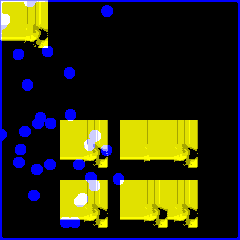

exit log_context_duration for Creating video
!!! {"Creating video": 19.3064603805542}
enter log_context_duration for Running Lenia
exit log_context_duration for Running Lenia
!!! {"Running Lenia": 15.315671920776367}
enter log_context_duration for Creating video


/tmp/ipykernel_4614/3690889046.py:103: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cm.get_cmap("jet")


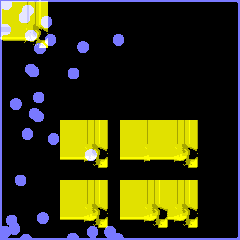

exit log_context_duration for Creating video
!!! {"Creating video": 16.285406351089478}


In [5]:
for i in range(2):
    main(
        SX,
        SY,
        borders=borders,
        creaFile="/tmp/crea1.pickle",
        device=device,
        logger=logger,
        mode=mode,
        zoom=1,
    )


enter log_context_duration for Running Lenia
exit log_context_duration for Running Lenia
!!! {"Running Lenia": 15.759877920150757}
enter log_context_duration for Creating video


/tmp/ipykernel_4614/3690889046.py:103: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cm.get_cmap("jet")


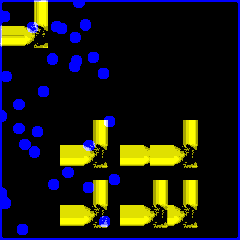

exit log_context_duration for Creating video
!!! {"Creating video": 21.447365760803223}
enter log_context_duration for Running Lenia
exit log_context_duration for Running Lenia
!!! {"Running Lenia": 15.304129362106323}
enter log_context_duration for Creating video


/tmp/ipykernel_4614/3690889046.py:103: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cm.get_cmap("jet")


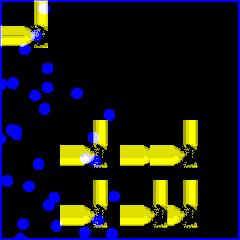

exit log_context_duration for Creating video
!!! {"Creating video": 21.37202215194702}


In [6]:
for i in range(2):
    main(
        SX,
        SY,
        borders=borders,
        creaFile="/tmp/crea2.pickle",
        device=device,
        logger=logger,
        mode=mode,
        zoom=1,
    )
